# Transition 

In this notebook, we compute transitional dynamics after an unexpected (zero probability) aggregate shock (MIT shock). "Zero probability" means that agents' behavior is not affected. For instance, they do not accumulate precautionary savings, because they simply do not expect the shock. 

#### Load packages

In [36]:
using Parameters
using Setfield
using Interpolations
using Plots
using Roots

#### Set up structures

In [37]:
@with_kw struct ModelParameters{T} # Economic Variables
    β :: T = 0.95
    γ :: T = 2.0
    ϵ :: T = 4.06
    χ :: T = 1.0
    ρ :: T = 0.9136 # Flodén and Lindé (2001)
    σ2 :: T = 0.0426 # Flodén and Lindé (2001)
end 

@with_kw struct NumericalParameters # Numerical Variables
    na   :: Int = 200 # asset grid
    na_c :: Int = 100
    amin :: Float64 = 0.0 
    amax :: Float64 = 50.0 
    ny   :: Int = 5 # income grid
    tol_pol :: Float64 = 1e-7
    max_iter :: Int = 500
end

# Load it already here, as it is needed below
n_par= NumericalParameters()

@with_kw struct ContainerHA{T} # T= Array{Float64,1}
    A  :: T  = zeros(n_par.na, n_par.ny) # policy function assets
    C  :: T  = zeros(n_par.na, n_par.ny) # policy function consumption
    N  :: T  = zeros(n_par.na, n_par.ny) # policy function hours worked
end

@with_kw struct Grids
    gridA :: Array{Float64,1} = zeros(n_par.na)         # asset grid
    Π :: Array{Float64,2} = zeros(n_par.ny, n_par.ny)   # transition matrix income
    gridθ :: Array{Float64,1} = zeros(n_par.ny)         # productivity grid
end

Grids

#### Discretization

In [38]:
function Rouwenhorst_AR1(ρ, σ2, N)

    p= (1+ρ)/2
    q= (1+ρ)/2
    
    # Construct Markov Chain recursively
    if N ==2
        tm= [p 1-p; 1-q q]
    elseif N>2
        tm= [p 1-p; 1-q q]
        for i in 2:N-1
            tm= p .* hcat( vcat(tm, zeros(1,i)), zeros(i+1,1) ) + 
            (1-p) .* hcat( zeros(i+1,1), vcat(tm, zeros(1,i)) ) +
            (1-q) .* hcat( vcat(zeros(1,i), tm), zeros(i+1,1) ) +
                q .* hcat( zeros(i+1,1), vcat(zeros(1,i), tm) )
            
            tm[2:end-1,:]= tm[2:end-1,:]./2 # divide all but the first and last row by two
        end
    else
        println("The number of grid points needs to be larger than two")
    end
    
    # Create state vector - here M is basically sqrt(iN-1)
    ψ= sqrt((σ2 / (1 - ρ^2))) * sqrt(N - 1)
    state= LinRange(-ψ, ψ, N)

    return state, tm

end # end Rouwenhorst_AR1 function

Rouwenhorst_AR1 (generic function with 1 method)

#### EGM (with endogenous labor)

In [39]:
function findMinimumConsumption(c, aprime, a, r, w, θ, γ, ϵ, χ)

    n= max.(0.0, 1.0 .- ( ( c.^(-γ) .* w .* θ) ./χ).^(-1/ϵ) ) # intra-temporal FOC

    rt= aprime + c - (1+r)*a - w*θ*n # budget

    return rt

end


function egm_step(m_par::ModelParameters, n_par::NumericalParameters, grids::Grids, Cprime, Cl, r, rprime, w)

    # Unpack
    @unpack_ModelParameters m_par
    @unpack_NumericalParameters n_par
    @unpack_Grids grids

    # Pre-allocation
    Ci= similar(Cprime, Float64)

    EUc= Cprime.^(-γ) * Π'  # RHS Euler (expectation)
    for y in 1:ny

        # unconstrained
        Cendog= ((1+rprime) .* β .* EUc[:,y]).^(-1/γ) # inter-temporal FOC (Euler)
        Nendog= max.(0.0, 1.0 .- ( ( Cendog.^(-γ) .* w .* gridθ[y]) ./χ).^(-1/ϵ) ) # intra-temporal FOC
        Aendog= (gridA .+ Cendog .- w.*Nendog.*gridθ[y]) ./ (1 + r) # budget constraint
        
        # constrained
        if Aendog[1] > amin            
            Cendog_c= collect(LinRange(Cl[y], Cendog[1], na_c)[1:na_c-1]) # get consumption on lower bound
            Nendog_c= max.(0.0, 1.0 .- ( ( Cendog_c.^(-γ) .* w .* gridθ[y]) ./χ).^(-1/ϵ) )
            Aendog_c= (amin .+ Cendog_c .- w.*Nendog_c.*gridθ[y]) ./ (1 + r)

            Cendog= append!(Cendog_c, Cendog)
            Aendog= append!(Aendog_c, Aendog)
        end

        itpC= LinearInterpolation(Aendog, Cendog, extrapolation_bc=Line())
        Ci[:,y]= itpC.(gridA)

    end

    return Ci

end

function egm(gV_conHA::ContainerHA, m_par::ModelParameters, n_par::NumericalParameters, grids::Grids, r, rprime, w)

    # Unpack
    @unpack_ContainerHA gV_conHA
    
    
    Ci= copy(C)
    difference= 1000.0
    it=1
    Cl= zeros(n_par.ny)


    # Find consumption at lower bound (constrained agents)
    for y in 1:n_par.ny
        Croot= (c -> findMinimumConsumption(c, n_par.amin, n_par.amin, r, w, grids.gridθ[y], m_par.γ, m_par.ϵ, m_par.χ)) # recover consumption if at lower bounds - Euler does not hold with equality - only use intra-temporal FOC and budget
        Cl[y]= find_zero(Croot, 1e-6 )
    end
    Cl[Cl.<=1e-6] .= 1e-6 # set min consumption


    while difference > n_par.tol_pol && it < n_par.max_iter
        Ci= egm_step(m_par, n_par, grids, C, Cl, r, rprime, w)
        # Check and update
        difference= maximum(abs.(C .- Ci))
        C= copy(Ci)
        it= it+1
    end # end while


    # Fill policy functions
    for y in 1:n_par.ny
        N[:,y]= max.(0.0, 1.0 .- ( ( C[:,y].^(-m_par.γ) .* w .* grids.gridθ[y]) ./m_par.χ).^(-1/m_par.ϵ) )
        A[:,y]= w .* N[:,y] .* grids.gridθ[y] .+ (1+r).*grids.gridA .- C[:,y]
    end

    gV_conHA= ContainerHA(A=A, C=C, N=N) 

    # println("Finished EGM in iteration = ", it, ", and diff = ", difference)

    return gV_conHA

end

egm (generic function with 1 method)

#### (Stationary) Distribution 

In [40]:
function weights_and_indices(A,gridA,na,ny)

    A_indices= zeros(Int, na, ny) 
    wei= zeros(Float64,na,ny) 

    for y in 1:ny
        # Indices
        A_indices[:,y] = searchsortedlast.(Ref(gridA), A[:,y])  # gives left bracket; 0 if below grid, na if above grid
    end
    A_indices[A_indices .== 0] .= 1
    A_indices[A_indices .== na] .= na-1
    for y in 1:ny
        wei[:,y]= (A[:,y] .- [gridA[i] for i in A_indices[:,y]]) ./ ([gridA[i+1] for i in A_indices[:,y]] .- [gridA[i] for i in A_indices[:,y]])
    end
    # should never be binding, but just to be save
    wei[wei.>1] .=1
    wei[wei.<0] .=0

    return wei, A_indices

end


function loop!(A_disti::Array{Float64,2},A_indices::Array{Int,2},wei::Array{Float64,2},Π::Array{Float64,2},A_dist::Array{Float64,2},na::Int,ny::Int)

    @inbounds for i in 1:na
        for s in 1:ny
            index= A_indices[i,s]
            lottery1= (1-wei[i,s]) * A_dist[i,s]
            lottery2= wei[i,s]* A_dist[i,s]
            for si in 1:ny
                A_disti[index,si] += lottery1 * Π[s,si]
                A_disti[index + 1,si] += lottery2 * Π[s,si] 
            end
        end
    end

end

function density_discretization(gV_conHA::ContainerHA, grids::Grids, n_par::NumericalParameters,A_dist)

    # Unpack
    @unpack_NumericalParameters n_par
    @unpack_Grids grids
    
    # retrieve indices and weights for lottery
    wei, A_indices= weights_and_indices(gV_conHA.A, gridA, na, ny)

    difference= 100.0
    it=1
    # iterate over discretized density to get fixed point
    while difference > 1e-10 && it < 10000
    
        # always pre-allocate to zero
        A_disti= zeros(Float64,na,ny) 

        loop!(A_disti, A_indices, wei, Π, A_dist, na, ny)

        difference= maximum(abs.(A_disti .- A_dist))
        A_dist= A_disti ./ sum(A_disti)
        it= it+1

    end

    it == 10000 ? println("density_discretization did not converge") : Nothing

    return A_dist

end

density_discretization (generic function with 1 method)

#### Initialize

In [41]:
m_par= ModelParameters{Float64}()
gV_conHA= ContainerHA{Array{Float64,2}}();

lnproductivtyGrid, transitionMatrix= Rouwenhorst_AR1(m_par.ρ,m_par.σ2,n_par.ny);
productivityGrid= exp.(lnproductivtyGrid)

gridA= n_par.amin .+ (collect(0:n_par.na-1)./n_par.na).^2 .* (n_par.amax - n_par.amin);
grids= Grids(gridA=gridA, Π=transitionMatrix, gridθ=productivityGrid);

#### Household asset demand

In [42]:
function householdAssetDemand(gV_conHA, m_par, n_par, grids, r, rprime, w)

    # EGM
    gV_conHA= egm(gV_conHA, m_par, n_par, grids, r, rprime, w);

    # Stationary distribution
    mA_dist= ones(n_par.na, n_par.ny) ./ (n_par.na * n_par.ny) 
    mA_dist= density_discretization(gV_conHA, grids, n_par, mA_dist)

    # Aggregates - Asset demand
    dA= sum(mA_dist .* gV_conHA.A)

    return dA

end

householdAssetDemand (generic function with 1 method)

#### Steady state

In [43]:
## Assume that production is linear in labor -> wage equals unity
# Wage
w= 1.0

# Interest rate
# r is now determined by market clearing
r = 0.03 # starting value

# Government bond supply - fixed
dB= 1.6



# Guess
Cguess= ones(n_par.na, n_par.ny) .* r .+ gridA;
gV_conHA= ContainerHA(C=Cguess);

### Iterate on asset market clearing - one could also use a root-finder to solve for r, but this is for illustration
differenceMarketClearing= 100.0
iterationMarketClearing=1
while differenceMarketClearing > 1e-5 && iterationMarketClearing < 300

    dA = householdAssetDemand(gV_conHA, m_par, n_par, grids, r, r, w)
    differenceMarketClearing= abs(dA - dB)

    println("Market clearing = ", differenceMarketClearing, " in iteration ", iterationMarketClearing)

    # Update
    r= r - 0.01*(dA - dB) # if demand for assets is bigger than supply, decrease interest rate

    iterationMarketClearing= iterationMarketClearing+1

end

r_ss= r
println("Equilibrium steady state interest rate ", r_ss)

### Construct steady state objects
# EGM
gV_conHA_ss= egm(gV_conHA, m_par, n_par, grids, r, r, w);

# Density
mA_dist= ones(n_par.na, n_par.ny) ./ (n_par.na * n_par.ny); 
mA_dist_ss= density_discretization(gV_conHA_ss, grids, n_par, mA_dist);


Market clearing = 0.1762415443267118 in iteration 1
Market clearing = 0.00893853797215205 in iteration 2
Market clearing = 0.0010501219881300372 in iteration 3
Market clearing = 0.0001268520690820285 in iteration 4
Market clearing = 1.537247646887785e-5 in iteration 5
Market clearing = 1.8636236300828557e-6 in iteration 6
Equilibrium steady state interest rate 0.028136257075438254


# Transition

So far, we repeated the steps from the other notebooks to construct the (initial) steady state of the economy. Implicitly, we assumed the following production function: $Y_t = Z_t L_t$, where $Z$ denotes aggregate productivity and $L_t$ denotes aggregate labor (in efficiency units) where in the steady state $Z=1$ such that the equilibrium wage also equals one as imposed.

In the following, we want to model an unexpected aggregate productivity shock.   

Before describing the computation of the transition after an unexpected shocks, let's define the household problem at time $t$ in recursive form.

\begin{align} \tag{HH}
V_t(a, e) = \max_{c, n, a} &\left\{u(c_t(a,e)) - \nu(n_t(a,e)) + \beta \sum_{e'}V_{t+1}(e', a') \mathcal{P}(e,e') \right\}
\\
c_t(a,e) + a_{t+1}(a,e) &= (1 + r_t)a + w_t \ e \ n_t(a,e)
\\
a_{t+1}(a,e) &\geq 0,
\end{align}

Note that we augmented the household problem by a labor choice, which is discussed in a separate notebook. Hence, the stochastic process is not over income, but over labor productivity $e$. 

Compared to the steady-state version of an earlier notebook, this household problem's value function and policy functions are a function of time. This is because aggregate productivity $Z_t$ and hence aggregate prices $(r_t, w_t)$ are time-varying. Note that households have perfect foresight over the transition. Once the shock hits the economy, they understand how it will play out. Therefore, we do not need to keep track of the aggregate distribution as a state variable, time is a sufficient statistic. 

---

Now to the computation. The MIT shock hits the economy in the initial steady state. Agents "wake up" under the new regime. Steady state objects are denoted by an asterisk $(^*)$. 
Assume that the economy returns to the steady state after $T$ periods. 

- With a sequence for the shock $\{Z_t\}_{t=1}^T$ we have sequence of wages $\{w_t\}_{t=1}^T$. 
- Guess a sequence for interest rates $\{r_t\}_{t=1}^T$
- Impose $r_T = r^*$, $c_T(a,y) = c^*(a,y)$. Then iterate backwards using the EGM method. 
    - Note that each iteration in the EGM is basically a step back (from future RHS of Euler equation, receive policy on current LHS). Instead of using a guess on the RHS, we use the policy at $t+1$, starting from $T$. 
- Given the sequence of policy functions, we can iterate the distributions forward. Start from the intial distribution $\lambda^* = \lambda^0$ and use the policy function $c_1(a,y)$ to construct $\lambda_1$ etc. Do so until $\lambda_T$. 
    - A first check whether the code is correct and whether $T$ is set large enough is to check whether $\lambda_T = \lambda^*$, since the economy should have returned to the steady state after this period.
- Given a sequence of policy functions and distributions, one can compute aggregates over the entire transition. 
- Check whether $A_T = A^*$. If not, increase $T$. 
- Check whether asset market clears over the entire transition path. If not, adjust the interest rate sequence $\{ r_t \}$ and repeat.  


### Simulate a MIT-Shock in Z (i.e. TFP): Y = ZN

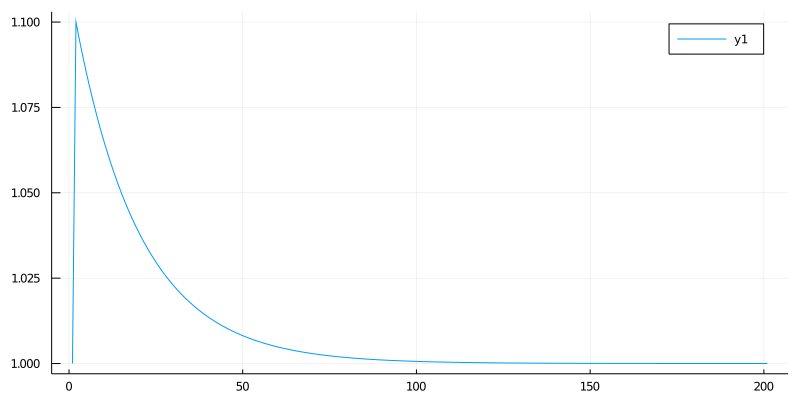

In [44]:
iT= 200 # transition period

dZ_ss= 1.0
dZ_shock= 1.1 # value of initial shock # 10% wage increase
dZ_rho= 0.95 # persistence of shock


vZ= ones(iT)
vZ[1]= dZ_shock*dZ_ss

for t in 2:iT
vZ[t]= vZ[t-1]^dZ_rho
end

plot(append!([dZ_ss],vZ))
plot!(size=(800,400))


Construct functions that iterate policy function backward and policy function forward

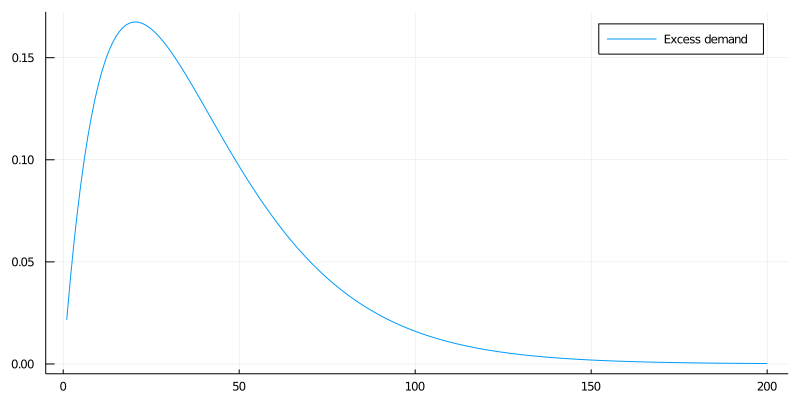

In [45]:
function backward_policy(C_terminal, N_terminal, A_terminal, m_par, n_par, grids, vr_t, vw_t, iT)
    # vw_t is path of wages
    # vr_t is path of interest rates
    
    mAPol_t= zeros(n_par.na, n_par.ny, iT)
    mNPol_t= zeros(n_par.na, n_par.ny, iT)
    mCPol_t= zeros(n_par.na, n_par.ny, iT)
    Cl= zeros(n_par.ny)

    wei_t= zeros(Float64, n_par.na,n_par.ny, iT)
    A_indices_t= zeros(Int, n_par.na, n_par.ny, iT)

    # Initialize
    mCPol_t[:,:,end]= copy(C_terminal)
    mNPol_t[:,:,end]= copy(N_terminal)
    mAPol_t[:,:,end]= copy(A_terminal)

    for t=iT-1:-1:1 #iterate backward

        r= vr_t[t]
        rprime= vr_t[t+1]
        w= vw_t[t]

        # Find consumption at lower bound (constrained agents)
        for y in 1:n_par.ny
            Croot= (c -> findMinimumConsumption(c, n_par.amin, n_par.amin, r, w, grids.gridθ[y], m_par.γ, m_par.ϵ, m_par.χ)) # recover consumption if at lower bounds - Euler does not hold with equality - only use intra-temporal FOC and budget
            Cl[y]= find_zero(Croot, 1e-6 )
        end
        Cl[Cl.<=1e-6] .= 1e-6 # set min consumption
        
        mCPol_t[:,:,t]= egm_step(m_par, n_par, grids, mCPol_t[:,:,t+1], Cl, r, rprime, w)

        # Fill policy functions
        for y in 1:n_par.ny
            mNPol_t[:,y,t]= max.(0.0, 1.0 .- ( ( mCPol_t[:,y,t].^(-m_par.γ) .* w .* grids.gridθ[y]) ./m_par.χ).^(-1/m_par.ϵ) )
            mAPol_t[:,y,t]= w .* mNPol_t[:,y,t] .* grids.gridθ[y] .+ (1+r).*grids.gridA .- mCPol_t[:,y,t]
        end

        # Save weights to iterate distribution
        wei_t[:,:,t], A_indices_t[:,:,t]= weights_and_indices(mAPol_t[:,:,t], gridA, n_par.na, n_par.ny)

    end


    return mAPol_t, wei_t, A_indices_t # could potentially also return mNPol_t and mCPol_t if needed

end


function density_forward(wei_t, A_indices_t, Π, ny,na, mA_dist, t)

    mAdisti= zeros(na,ny)

    loop!(mAdisti,A_indices_t[:,:,t],wei_t[:,:,t],Π,mA_dist,na,ny)

    mA_dist= mAdisti ./ sum(mAdisti)

    return mA_dist

end


function forward_distribution(mA_dist_ss, wei_t, A_indices_t, grids, n_par, iT)

    # Initialize
    mA_dist_t= zeros(Float64, n_par.na,n_par.ny, iT)
    mA_dist_t[:,:,1]= copy(mA_dist_ss) # start from initial distribution (iterate forwards)

    for t in 1:iT-1
        # Iterate distribution forward
        mA_dist_t[:,:,t+1]= density_forward(wei_t, A_indices_t, grids.Π, n_par.ny, n_par.na, mA_dist_t[:,:,t], t)
    end # end forward iteration 

    return mA_dist_t

end





# Run once

vr_t= ones(iT+1) .* r_ss # Interest rate guess over transition

vw_t= vZ # wage over transition equals productivity
mAPol_t, wei_t, A_indices_t= backward_policy(gV_conHA_ss.C, gV_conHA_ss.N, gV_conHA_ss.A, m_par, n_par, grids, vr_t, vw_t, iT);
mA_dist_t= forward_distribution(mA_dist_ss, wei_t, A_indices_t, grids, n_par, iT); 

# Aggregates
vA= ones(iT)
for t in 1:iT
    vA[t]= sum(mAPol_t[:,:,t] .* mA_dist_t[:,:,t])
end

plot(vA .- dB, label="Excess demand")
plot!(size=(800,400))


We see that excess demand, given our interest rate guess, is not equal to zero. Hence we repeat the actions from above, but adjust the interest rate path to achieve an excess demand over the transition of zero. Note, given the crude adjusting rule, the code takes quite long, but this is again for illustration.

In [46]:

function full_transition(gV_conHA_ss, mA_dist_ss, m_par, n_par, grids, r_ss, vZ, iT, dB)

# Updating weights
dSpeed   = 3.0
dDecay   = 0.01
weight  = exp.(-dDecay .* collect(0:iT)) #exponentially decaying weights
weight  = dSpeed .* weight ./ sum(weight)


# guess
vr_t= ones(iT+1) .* r_ss # Interest rate guess over transition

# store vr_t
mr_t= zeros(500,iT+1)
mr_t[1,:]= vr_t 

# pre-allocation
vw_t= vZ
vA= ones(iT+1) .* dB


assetMarketClearing_transition= 1.0
iteration_transition= 1
while assetMarketClearing_transition > 1e-6 && iteration_transition < 500

    mAPol_t, wei_t, A_indices_t= backward_policy(gV_conHA_ss.C, gV_conHA_ss.N, gV_conHA_ss.A, m_par, n_par, grids, vr_t, vw_t, iT);
    mA_dist_t= forward_distribution(mA_dist_ss, wei_t, A_indices_t, grids, n_par, iT); 

    # Aggregates
    for t in 1:iT
        vA[t]= sum(mAPol_t[:,:,t] .* mA_dist_t[:,:,t])
    end

    # Check
    assetMarketClearing_transition= maximum(abs.(vA .- dB))
    # vBM_t= vA .- dB
    # assetMarketClearing_transition = sqrt((sum(vBM_t .* vBM_t))/iT)


    if mod(iteration_transition, 50) == 0
        println("Market clearing over transition: ", assetMarketClearing_transition, " in iteration ", iteration_transition)
    end

    # Updating
    vr_t= vr_t .- weight .* (vA .- dB) 


    iteration_transition= iteration_transition + 1

    mr_t[iteration_transition,:]= vr_t 

end

println("Finished in iteration ", iteration_transition, " with market clearing ", assetMarketClearing_transition)

return vr_t, mr_t

end

vr_t, mr_t= full_transition(gV_conHA_ss, mA_dist_ss, m_par, n_par, grids, r_ss, vZ, iT, dB);

Market clearing over transition: 0.0007562178670093012 in iteration 50
Market clearing over transition: 0.00016361401730868863 in iteration 100
Market clearing over transition: 3.633728178087381e-5 in iteration 150
Market clearing over transition: 1.0847134199298836e-5 in iteration 200
Market clearing over transition: 2.6364830838510045e-6 in iteration 250
Finished in iteration 295 with market clearing 9.826395366285823e-7


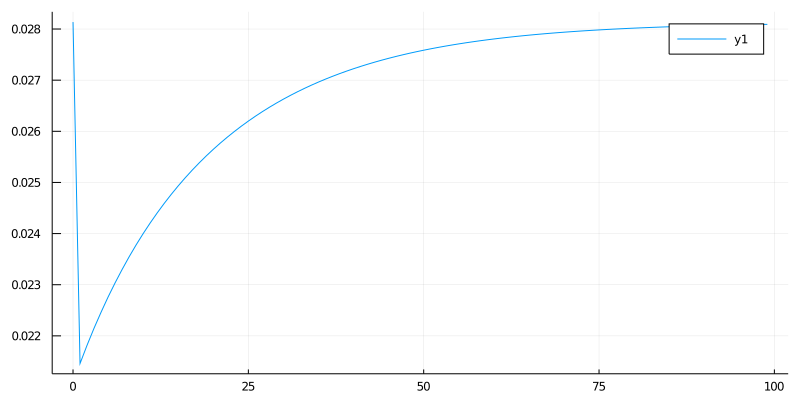

In [47]:
plot(collect(0:iT+1)[1:100], append!([r_ss],vr_t)[1:100])
plot!(size=(800,400))


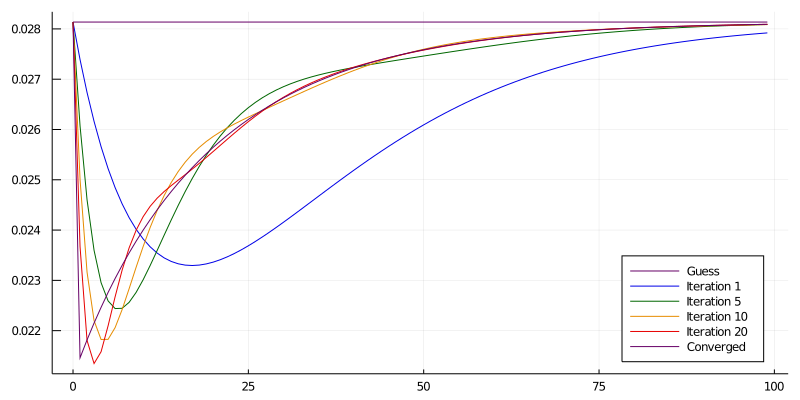

In [48]:
last_index= length(sum(mr_t,dims=2)) - sum(sum(mr_t,dims=2) .== 0)

plot(collect(0:iT+1)[1:100], append!([r],mr_t[1,:])[1:100], label="Guess", palette=:darkrainbow, legend=:bottomright)
plot!(collect(0:iT+1)[1:100], append!([r],mr_t[2,:])[1:100], label="Iteration 1")
plot!(collect(0:iT+1)[1:100], append!([r],mr_t[6,:])[1:100], label= "Iteration 5")
plot!(collect(0:iT+1)[1:100], append!([r],mr_t[11,:])[1:100], label="Iteration 10")
plot!(collect(0:iT+1)[1:100], append!([r],mr_t[21,:])[1:100], label="Iteration 20")
plot!(collect(0:iT+1)[1:100], append!([r],mr_t[last_index,:])[1:100], label="Converged")
plot!(size=(800,400))